# Getting Started with Temporian

In [1]:
import temporian as tp

import pandas as pd
import numpy as np

In [2]:
# EventSet with indexes
evset = tp.event_set(
    timestamps=["2023-02-04", "2023-02-06", "2023-02-07", "2023-02-07"],
    features={
        "feature_1": [0.5, 0.6, np.nan, 0.9],
        "feature_2": ["red", "blue", "red", "blue"],
        "feature_3":  [10.0, -1.0, 5.0, 5.0],
    },
    indexes=["feature_2"],
)
evset

timestamp,feature_1,feature_3
2023-02-06 00:00:00+00:00,0.6,-1
2023-02-07 00:00:00+00:00,0.9,5
timestamp,feature_1,feature_3
2023-02-04 00:00:00+00:00,0.5,10
2023-02-07 00:00:00+00:00,nan,5


In [3]:
# Generate a synthetic dataset
timestamps = np.arange(0, 100, 0.1)
n = len(timestamps)
noise = 0.1 * np.random.randn(n)
trend = 0.01 * timestamps
season = 0.4 * np.sin(timestamps)

# Convention: 'df_' for DataFrame
df_signals = pd.DataFrame(
    {
        "timestamp": timestamps,
        "noise": noise,
        "trend": trend,
        "season": season,
        "signal": noise + trend + season,
    }
)

df_signals

,timestamp,noise,trend,season,signal
0,0.0,0.156910,0.000,0.000000,0.156910
1,0.1,-0.072393,0.001,0.039933,-0.031460
2,0.2,-0.031852,0.002,0.079468,0.049616
3,0.3,-0.119600,0.003,0.118208,0.001609
4,0.4,0.052202,0.004,0.155767,0.211969
...,...,...,...,...,...
995,99.5,0.044176,0.995,-0.343118,0.696057
996,99.6,-0.079391,0.996,-0.320879,0.595731
997,99.7,-0.058139,0.997,-0.295433,0.643428
998,99.8,-0.140312,0.998,-0.267035,0.590653


In [4]:
# Convert the DataFrame into a Temporian EventSet
evset_signals = tp.from_pandas(df_signals)

evset_signals

timestamp,noise,trend,season,signal
0,0.1569,0,0,0.1569
0.1,-0.07239,0.001,0.03993,-0.03146
0.2,-0.03185,0.002,0.07947,0.04962
0.3,-0.1196,0.003,0.1182,0.001609
0.4,0.0522,0.004,0.1558,0.212
…,…,…,…,…


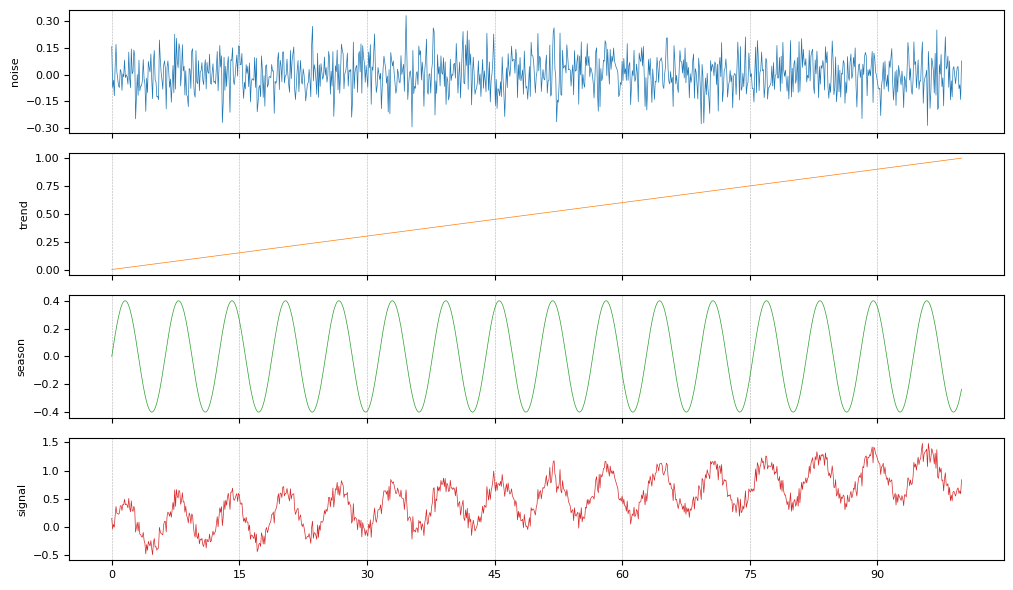

In [5]:
# Plot the dataset
_ = evset_signals.plot()

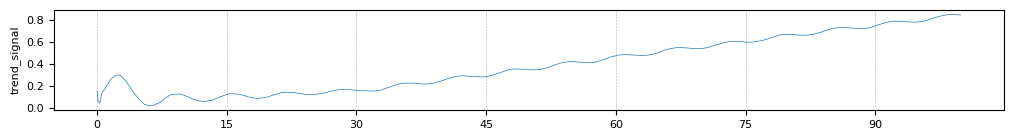

In [7]:
# Pick only one feature
signal = evset_signals["signal"]

# Moving avg
# To extract only the long-term trend, the sine and noise signals are first 
# removed using a moving average over a large moving window (they have zero mean).

trend = signal.simple_moving_average(tp.duration.seconds(30))

# Let's rename the feature by adding a prefix
trend = trend.prefix("trend_")
trend.plot()

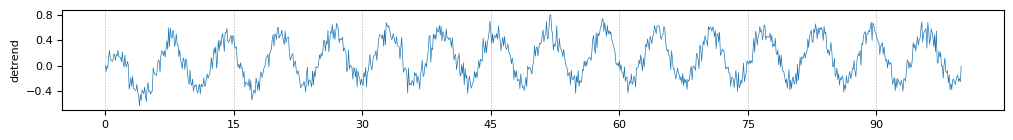

In [8]:
# Remove the slow 'trend' to get 'season'
detrend = signal - trend

# Rename resulting feature
detrend = detrend.rename("detrend")

detrend.plot()


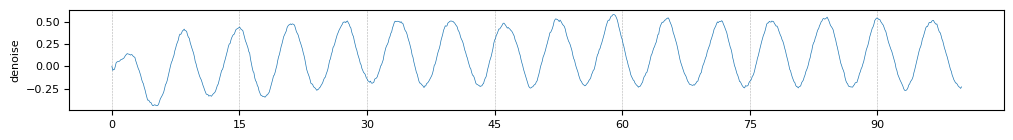

In [9]:
# Using a shorter moving average, we can filter out the noise.

denoise = detrend.simple_moving_average(tp.duration.seconds(1.5)).rename("denoise")
denoise.plot()

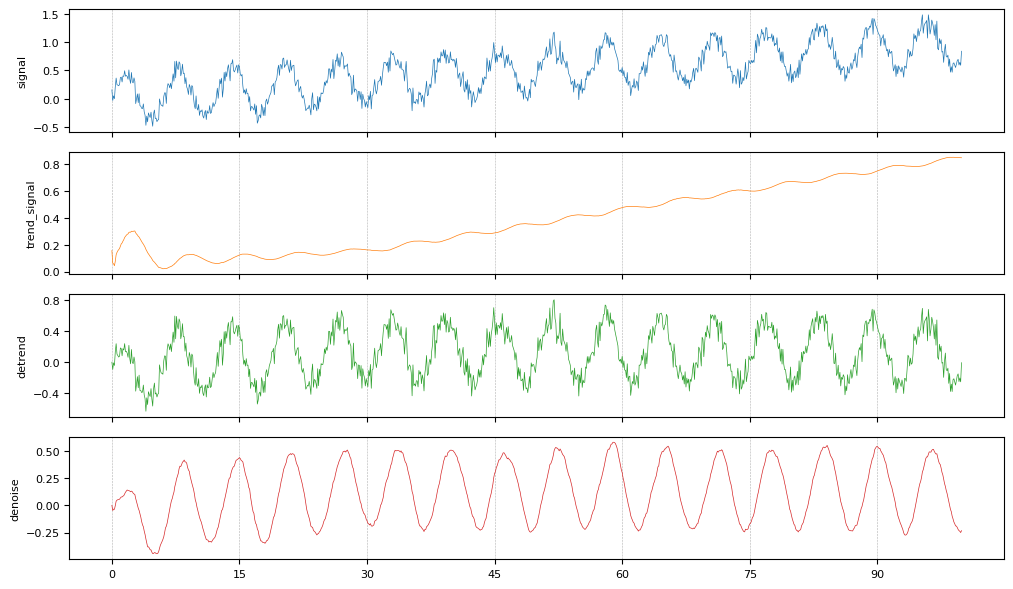

In [10]:
# Pack results to show all plots together
evset_result = tp.glue(
    signal,
    trend,
    detrend,
    denoise
)

evset_result.plot()


In [14]:
%pip install bokeh

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Estimate numeric derivative

# Time step
delta_t = 1

# Increment in y axis
y = denoise
y_lag = y.lag(delta_t)
delta_y = y - y_lag.resample(y)

# Remember the formula? :)
derivative = delta_y / delta_t

#plt.backend('matplotlib')
# Also, let's use an interactive plot just for fun.
derivative.plot(interactive=True, width_px=800)

In [17]:

# Two devices with overlapping timestamps
df_device_1 = df_signals[:900].copy()
df_device_2 = df_signals[300:].copy()

# Add a column with device_id and concat
df_device_1["device_id"] = "Device 1"
df_device_2["device_id"] = "Device 2"
df_both_devices = pd.concat([df_device_1, df_device_2])

# Create evset using 'device_id' as index
evset_devices = tp.from_pandas(df_both_devices, indexes=["device_id"])
evset_devices

timestamp,noise,trend,season,signal
0,0.1569,0,0,0.1569
0.1,-0.07239,0.001,0.03993,-0.03146
0.2,-0.03185,0.002,0.07947,0.04962
0.3,-0.1196,0.003,0.1182,0.001609
0.4,0.0522,0.004,0.1558,0.212
…,…,…,…,…
timestamp,noise,trend,season,signal
30,-0.01214,0.3,-0.3952,-0.1073
30.1,-0.0707,0.301,-0.3871,-0.1568
30.2,0.1264,0.302,-0.3751,0.05331


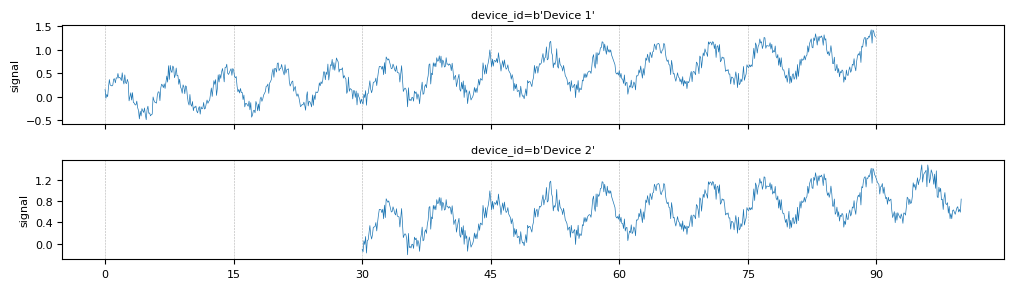

In [18]:
evset_devices["signal"].plot()

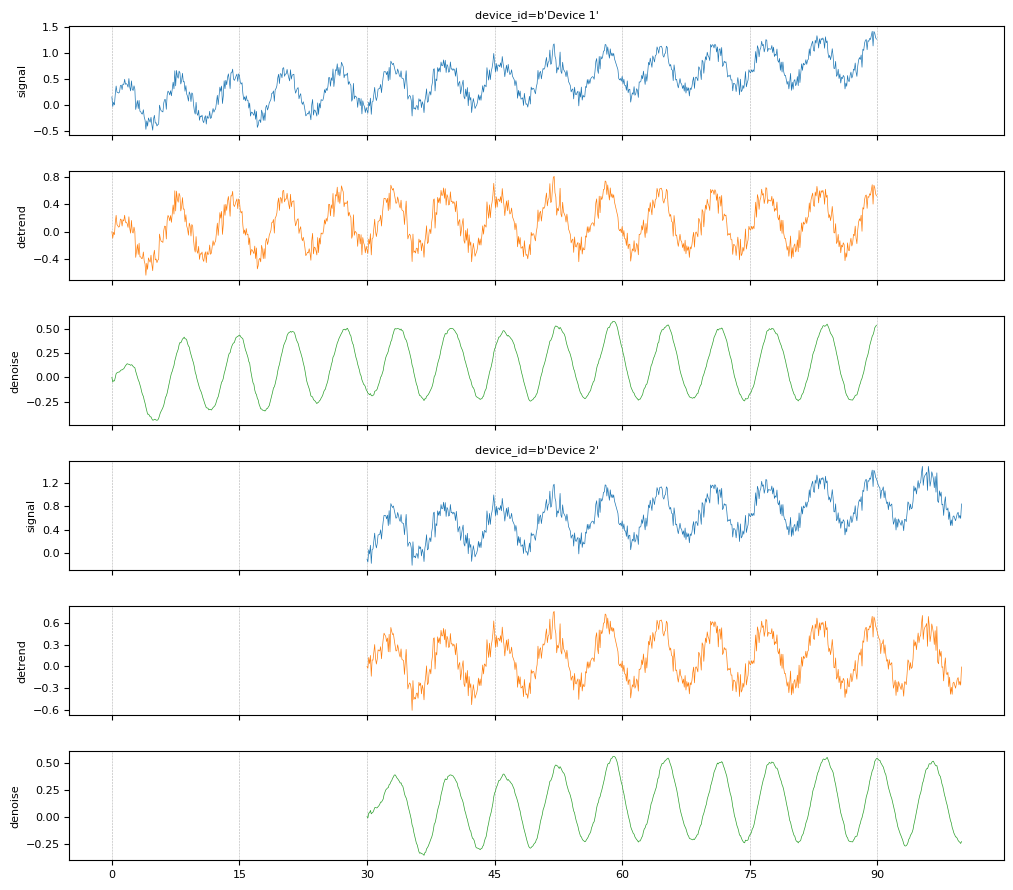

In [19]:
# Apply some operations
trend_i = evset_devices["signal"].simple_moving_average(tp.duration.seconds(30))
detrend_i = evset_devices["signal"] - trend_i
denoise_i = detrend_i.simple_moving_average(tp.duration.seconds(1.5))

# Plot for each index
tp.glue(evset_devices["signal"],
        detrend_i.rename("detrend"),
        denoise_i.rename("denoise")
       ).plot()